## Import datasets

In [1]:
import torch
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
from model import *
from utils import *

## Data transformation

In [4]:
class CIFAR10_ds(datasets.CIFAR10):
    def __init__(self, root=".", train=True, download=True, transform= None):
        super().__init__(root=root, train=train, download=download, transform=transform)
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.data[idx], self.targets[idx]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label
 

In [5]:
train_transforms = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, 
                         min_width=16, fill_value=(0.4914, 0.4822 ,0.4465), mask_fill_value = None),
        A.HorizontalFlip(p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
        ToTensorV2(),
    ]
)

In [6]:
test_transforms = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2()
])

In [7]:
train_data = CIFAR10_ds(root=".", train=True, download=True, transform=train_transforms)
test_data = CIFAR10_ds(root=".", train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_data

Dataset CIFAR10_ds
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose([
             ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.05, 0.05), shift_limit_y=(-0.05, 0.05), scale_limit=(-0.050000000000000044, 0.050000000000000044), rotate_limit=(-15, 15), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
             CoarseDropout(always_apply=False, p=0.5, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value=None),
             HorizontalFlip(always_apply=False, p=0.5),
             RGBShift(always_apply=False, p=0.5, r_shift_limit=(-15, 15), g_shift_limit=(-15, 15), b_shift_limit=(-15, 15)),
             RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
             Normalize(always_apply=False, p=1.0, me

In [9]:
batch_size = 128

kwargs = dict(shuffle=True, batch_size=batch_size) 

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

In [10]:
classes = train_data.classes

class_count = {}
for _, index in train_data:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)

{'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}


## Sample image with augmentation

images.shape: torch.Size([128, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


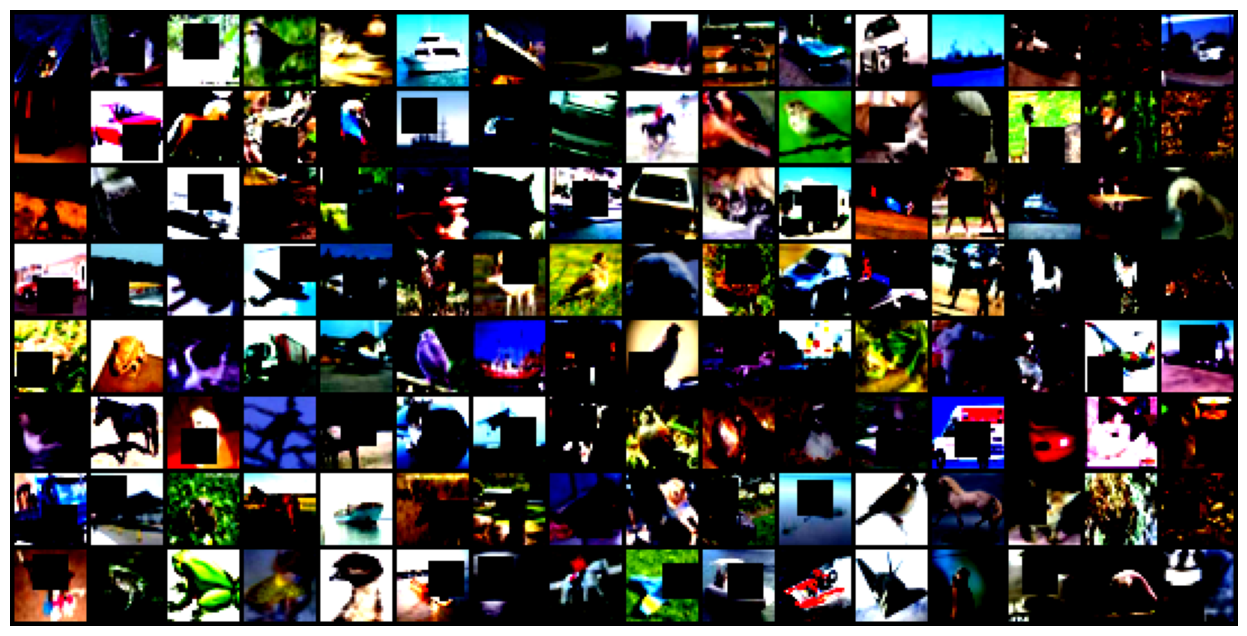

In [11]:
for images, label in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Neural net summary

In [12]:
get_summary(Net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             160
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 24, 30, 30]           3,480
      BatchNorm2d-10           [-1, 24, 30, 30]              48
             ReLU-11           [-1, 24, 30, 30]               0
          Dropout-12           [-1, 24, 30, 30]               0
    ResidualBlock-13           [-1, 24, 30, 30]               0
           Conv2d-14           [-1, 32,

<function torchsummary.torchsummary.summary(model, input_size, batch_size=-1, device='cuda')>

## Training the data and calculating validation results

In [13]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [14]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# New Line
train_criterion = nn.CrossEntropyLoss() #Loss function
test_criterion = nn.CrossEntropyLoss() #Loss function
num_epochs = 50

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train_acc_val, train_loss = train(model, device, train_loader, optimizer, train_criterion)
    print(train_acc_val)
    test_acc_val, test_loss = test(model, device, test_loader, test_criterion)
    
    train_acc.append(train_acc_val) #Storing training loss for each epoch
    train_losses.append(train_loss)
    test_acc.append(test_acc_val) #Storing testing loss for each epoch
    test_losses.append(test_loss)
    
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

Epoch 1


Train: Loss=1.5274 Batch_id=390 Accuracy=35.10: 100%|█| 391/391 [06:52<00:00,  1


35.104
Test set: Average loss: 1.3249, Accuracy: 5311/10000 (53.11%)

Epoch 1: SGD lr 0.0500 -> 0.0400
Epoch 2


Train: Loss=1.4433 Batch_id=390 Accuracy=50.10: 100%|█| 391/391 [06:23<00:00,  1


50.096
Test set: Average loss: 1.1079, Accuracy: 6097/10000 (60.97%)

Epoch 2: SGD lr 0.0400 -> 0.0320
Epoch 3


Train: Loss=1.1618 Batch_id=390 Accuracy=56.92: 100%|█| 391/391 [06:18<00:00,  1


56.922
Test set: Average loss: 0.9604, Accuracy: 6637/10000 (66.37%)

Epoch 3: SGD lr 0.0320 -> 0.0256
Epoch 4


Train: Loss=1.0516 Batch_id=390 Accuracy=61.17: 100%|█| 391/391 [06:14<00:00,  1


61.17
Test set: Average loss: 0.8530, Accuracy: 7046/10000 (70.46%)

Epoch 4: SGD lr 0.0256 -> 0.0205
Epoch 5


Train: Loss=1.1263 Batch_id=390 Accuracy=63.61: 100%|█| 391/391 [05:52<00:00,  1


63.614
Test set: Average loss: 0.7720, Accuracy: 7385/10000 (73.85%)

Epoch 5: SGD lr 0.0205 -> 0.0164
Epoch 6


Train: Loss=0.9337 Batch_id=390 Accuracy=65.60: 100%|█| 391/391 [05:55<00:00,  1


65.596
Test set: Average loss: 0.7206, Accuracy: 7493/10000 (74.93%)

Epoch 6: SGD lr 0.0164 -> 0.0131
Epoch 7


Train: Loss=1.0225 Batch_id=390 Accuracy=66.88: 100%|█| 391/391 [05:31<00:00,  1


66.884
Test set: Average loss: 0.6959, Accuracy: 7574/10000 (75.74%)

Epoch 7: SGD lr 0.0131 -> 0.0105
Epoch 8


Train: Loss=0.8658 Batch_id=390 Accuracy=67.92: 100%|█| 391/391 [05:28<00:00,  1


67.922
Test set: Average loss: 0.6672, Accuracy: 7703/10000 (77.03%)

Epoch 8: SGD lr 0.0105 -> 0.0084
Epoch 9


Train: Loss=0.7853 Batch_id=390 Accuracy=68.44: 100%|█| 391/391 [05:26<00:00,  1


68.442
Test set: Average loss: 0.6359, Accuracy: 7832/10000 (78.32%)

Epoch 9: SGD lr 0.0084 -> 0.0067
Epoch 10


Train: Loss=1.0732 Batch_id=390 Accuracy=69.27: 100%|█| 391/391 [05:27<00:00,  1


69.274
Test set: Average loss: 0.6255, Accuracy: 7869/10000 (78.69%)

Epoch 10: SGD lr 0.0067 -> 0.0054
Epoch 11


Train: Loss=0.8300 Batch_id=390 Accuracy=70.27: 100%|█| 391/391 [05:26<00:00,  1


70.272
Test set: Average loss: 0.6274, Accuracy: 7892/10000 (78.92%)

Epoch 11: SGD lr 0.0054 -> 0.0043
Epoch 12


Train: Loss=0.7966 Batch_id=390 Accuracy=70.40: 100%|█| 391/391 [05:26<00:00,  1


70.398
Test set: Average loss: 0.6030, Accuracy: 7956/10000 (79.56%)

Epoch 12: SGD lr 0.0043 -> 0.0034
Epoch 13


Train: Loss=0.8753 Batch_id=390 Accuracy=70.61: 100%|█| 391/391 [05:28<00:00,  1


70.612
Test set: Average loss: 0.6091, Accuracy: 7951/10000 (79.51%)

Epoch 13: SGD lr 0.0034 -> 0.0027
Epoch 14


Train: Loss=0.9783 Batch_id=390 Accuracy=70.98: 100%|█| 391/391 [05:29<00:00,  1


70.976
Test set: Average loss: 0.5974, Accuracy: 7965/10000 (79.65%)

Epoch 14: SGD lr 0.0027 -> 0.0022
Epoch 15


Train: Loss=0.8119 Batch_id=390 Accuracy=71.30: 100%|█| 391/391 [05:27<00:00,  1


71.304
Test set: Average loss: 0.5999, Accuracy: 7988/10000 (79.88%)

Epoch 15: SGD lr 0.0022 -> 0.0018
Epoch 16


Train: Loss=0.7704 Batch_id=390 Accuracy=71.39: 100%|█| 391/391 [05:27<00:00,  1


71.39
Test set: Average loss: 0.5843, Accuracy: 8033/10000 (80.33%)

Epoch 16: SGD lr 0.0018 -> 0.0014
Epoch 17


Train: Loss=0.9245 Batch_id=390 Accuracy=71.72: 100%|█| 391/391 [05:35<00:00,  1


71.724
Test set: Average loss: 0.5820, Accuracy: 8035/10000 (80.35%)

Epoch 17: SGD lr 0.0014 -> 0.0011
Epoch 18


Train: Loss=0.6594 Batch_id=390 Accuracy=71.68: 100%|█| 391/391 [05:40<00:00,  1


71.678
Test set: Average loss: 0.5829, Accuracy: 8022/10000 (80.22%)

Epoch 18: SGD lr 0.0011 -> 0.0009
Epoch 19


Train: Loss=0.8690 Batch_id=390 Accuracy=71.92: 100%|█| 391/391 [03:57<00:00,  1


71.924
Test set: Average loss: 0.5793, Accuracy: 8034/10000 (80.34%)

Epoch 19: SGD lr 0.0009 -> 0.0007
Epoch 20


Train: Loss=0.6340 Batch_id=390 Accuracy=71.96: 100%|█| 391/391 [03:26<00:00,  1


71.96
Test set: Average loss: 0.5787, Accuracy: 8030/10000 (80.30%)

Epoch 20: SGD lr 0.0007 -> 0.0006
Epoch 21


Train: Loss=0.7649 Batch_id=390 Accuracy=71.79: 100%|█| 391/391 [03:25<00:00,  1


71.786
Test set: Average loss: 0.5728, Accuracy: 8051/10000 (80.51%)

Epoch 21: SGD lr 0.0006 -> 0.0005
Epoch 22


Train: Loss=0.7003 Batch_id=390 Accuracy=71.91: 100%|█| 391/391 [03:25<00:00,  1


71.914
Test set: Average loss: 0.5726, Accuracy: 8049/10000 (80.49%)

Epoch 22: SGD lr 0.0005 -> 0.0004
Epoch 23


Train: Loss=0.8840 Batch_id=390 Accuracy=72.03: 100%|█| 391/391 [03:29<00:00,  1


72.034
Test set: Average loss: 0.5713, Accuracy: 8061/10000 (80.61%)

Epoch 23: SGD lr 0.0004 -> 0.0003
Epoch 24


Train: Loss=0.8650 Batch_id=390 Accuracy=72.15: 100%|█| 391/391 [03:25<00:00,  1


72.154
Test set: Average loss: 0.5719, Accuracy: 8056/10000 (80.56%)

Epoch 24: SGD lr 0.0003 -> 0.0002
Epoch 25


Train: Loss=0.7763 Batch_id=390 Accuracy=72.48: 100%|█| 391/391 [03:25<00:00,  1


72.484
Test set: Average loss: 0.5704, Accuracy: 8064/10000 (80.64%)

Epoch 25: SGD lr 0.0002 -> 0.0002
Epoch 26


Train: Loss=0.6234 Batch_id=390 Accuracy=72.36: 100%|█| 391/391 [03:26<00:00,  1


72.358
Test set: Average loss: 0.5688, Accuracy: 8058/10000 (80.58%)

Epoch 26: SGD lr 0.0002 -> 0.0002
Epoch 27


Train: Loss=0.7288 Batch_id=390 Accuracy=71.88: 100%|█| 391/391 [03:30<00:00,  1


71.876
Test set: Average loss: 0.5701, Accuracy: 8063/10000 (80.63%)

Epoch 27: SGD lr 0.0002 -> 0.0001
Epoch 28


Train: Loss=0.7351 Batch_id=390 Accuracy=72.27: 100%|█| 391/391 [03:25<00:00,  1


72.268
Test set: Average loss: 0.5661, Accuracy: 8065/10000 (80.65%)

Epoch 28: SGD lr 0.0001 -> 0.0001
Epoch 29


Train: Loss=0.7420 Batch_id=390 Accuracy=72.13: 100%|█| 391/391 [03:31<00:00,  1


72.128
Test set: Average loss: 0.5692, Accuracy: 8060/10000 (80.60%)

Epoch 29: SGD lr 0.0001 -> 0.0001
Epoch 30


Train: Loss=0.7218 Batch_id=390 Accuracy=72.51: 100%|█| 391/391 [03:30<00:00,  1


72.506
Test set: Average loss: 0.5677, Accuracy: 8066/10000 (80.66%)

Epoch 30: SGD lr 0.0001 -> 0.0001
Epoch 31


Train: Loss=0.7941 Batch_id=390 Accuracy=72.35: 100%|█| 391/391 [03:25<00:00,  1


72.346
Test set: Average loss: 0.5680, Accuracy: 8076/10000 (80.76%)

Epoch 31: SGD lr 0.0001 -> 0.0000
Epoch 32


Train: Loss=0.8096 Batch_id=390 Accuracy=72.26: 100%|█| 391/391 [03:25<00:00,  1


72.258
Test set: Average loss: 0.5736, Accuracy: 8048/10000 (80.48%)

Epoch 32: SGD lr 0.0000 -> 0.0000
Epoch 33


Train: Loss=0.7432 Batch_id=390 Accuracy=71.93: 100%|█| 391/391 [03:28<00:00,  1


71.926
Test set: Average loss: 0.5690, Accuracy: 8061/10000 (80.61%)

Epoch 33: SGD lr 0.0000 -> 0.0000
Epoch 34


Train: Loss=0.5790 Batch_id=390 Accuracy=72.23: 100%|█| 391/391 [03:27<00:00,  1


72.228
Test set: Average loss: 0.5687, Accuracy: 8063/10000 (80.63%)

Epoch 34: SGD lr 0.0000 -> 0.0000
Epoch 35


Train: Loss=0.6638 Batch_id=390 Accuracy=72.36: 100%|█| 391/391 [03:32<00:00,  1


72.358
Test set: Average loss: 0.5650, Accuracy: 8077/10000 (80.77%)

Epoch 35: SGD lr 0.0000 -> 0.0000
Epoch 36


Train: Loss=0.7035 Batch_id=390 Accuracy=72.29: 100%|█| 391/391 [03:27<00:00,  1


72.292
Test set: Average loss: 0.5643, Accuracy: 8079/10000 (80.79%)

Epoch 36: SGD lr 0.0000 -> 0.0000
Epoch 37


Train: Loss=0.6880 Batch_id=390 Accuracy=72.40: 100%|█| 391/391 [03:25<00:00,  1


72.404
Test set: Average loss: 0.5666, Accuracy: 8071/10000 (80.71%)

Epoch 37: SGD lr 0.0000 -> 0.0000
Epoch 38


Train: Loss=0.8704 Batch_id=390 Accuracy=71.92: 100%|█| 391/391 [03:25<00:00,  1


71.92
Test set: Average loss: 0.5682, Accuracy: 8067/10000 (80.67%)

Epoch 38: SGD lr 0.0000 -> 0.0000
Epoch 39


Train: Loss=0.6965 Batch_id=390 Accuracy=72.73: 100%|█| 391/391 [03:18<00:00,  1


72.728
Test set: Average loss: 0.5695, Accuracy: 8078/10000 (80.78%)

Epoch 39: SGD lr 0.0000 -> 0.0000
Epoch 40


Train: Loss=0.7426 Batch_id=390 Accuracy=72.22: 100%|█| 391/391 [03:15<00:00,  2


72.22
Test set: Average loss: 0.5710, Accuracy: 8056/10000 (80.56%)

Epoch 40: SGD lr 0.0000 -> 0.0000
Epoch 41


Train: Loss=0.8107 Batch_id=390 Accuracy=72.45: 100%|█| 391/391 [03:14<00:00,  2


72.452
Test set: Average loss: 0.5702, Accuracy: 8076/10000 (80.76%)

Epoch 41: SGD lr 0.0000 -> 0.0000
Epoch 42


Train: Loss=0.8769 Batch_id=390 Accuracy=72.39: 100%|█| 391/391 [03:14<00:00,  2


72.388
Test set: Average loss: 0.5685, Accuracy: 8068/10000 (80.68%)

Epoch 42: SGD lr 0.0000 -> 0.0000
Epoch 43


Train: Loss=0.7584 Batch_id=390 Accuracy=72.13: 100%|█| 391/391 [03:14<00:00,  2


72.126
Test set: Average loss: 0.5688, Accuracy: 8063/10000 (80.63%)

Epoch 43: SGD lr 0.0000 -> 0.0000
Epoch 44


Train: Loss=0.8295 Batch_id=390 Accuracy=72.23: 100%|█| 391/391 [03:15<00:00,  2


72.232
Test set: Average loss: 0.5701, Accuracy: 8065/10000 (80.65%)

Epoch 44: SGD lr 0.0000 -> 0.0000
Epoch 45


Train: Loss=0.9549 Batch_id=390 Accuracy=72.46: 100%|█| 391/391 [03:13<00:00,  2


72.458
Test set: Average loss: 0.5714, Accuracy: 8056/10000 (80.56%)

Epoch 45: SGD lr 0.0000 -> 0.0000
Epoch 46


Train: Loss=1.0841 Batch_id=390 Accuracy=72.68: 100%|█| 391/391 [03:12<00:00,  2


72.678
Test set: Average loss: 0.5657, Accuracy: 8076/10000 (80.76%)

Epoch 46: SGD lr 0.0000 -> 0.0000
Epoch 47


Train: Loss=0.9027 Batch_id=390 Accuracy=72.33: 100%|█| 391/391 [03:11<00:00,  2


72.332
Test set: Average loss: 0.5727, Accuracy: 8057/10000 (80.57%)

Epoch 47: SGD lr 0.0000 -> 0.0000
Epoch 48


Train: Loss=0.9301 Batch_id=390 Accuracy=72.28: 100%|█| 391/391 [03:11<00:00,  2


72.284
Test set: Average loss: 0.5703, Accuracy: 8056/10000 (80.56%)

Epoch 48: SGD lr 0.0000 -> 0.0000
Epoch 49


Train: Loss=0.9009 Batch_id=390 Accuracy=72.26: 100%|█| 391/391 [03:12<00:00,  2


72.262
Test set: Average loss: 0.5669, Accuracy: 8068/10000 (80.68%)

Epoch 49: SGD lr 0.0000 -> 0.0000
Epoch 50


Train: Loss=0.8993 Batch_id=390 Accuracy=72.45: 100%|█| 391/391 [03:16<00:00,  1


72.452
Test set: Average loss: 0.5694, Accuracy: 8055/10000 (80.55%)

Epoch 50: SGD lr 0.0000 -> 0.0000


## Plots

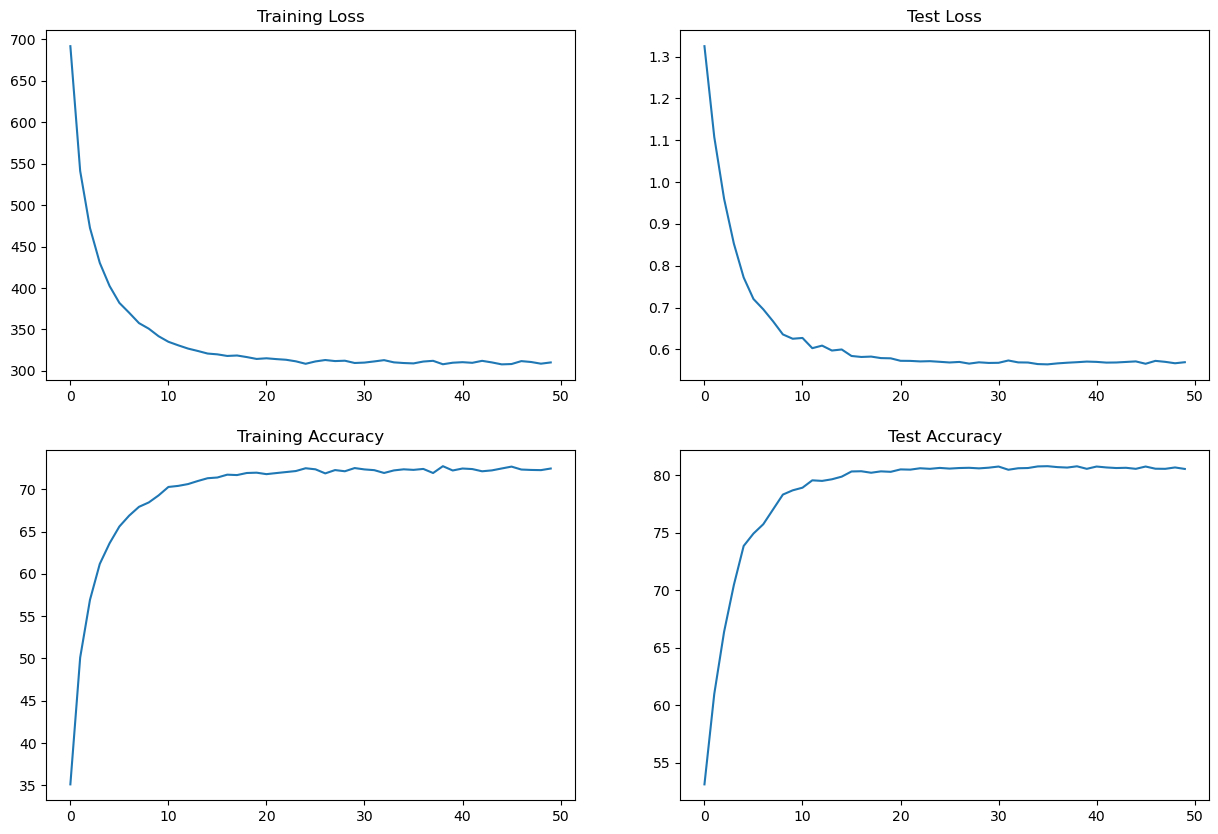

In [15]:
plot_loss(train_losses, train_acc, test_losses, test_acc)

## Misclassified dataset

In [16]:
model.eval()

incorrect_examples = []
incorrect_labels = []
incorrect_pred = []

for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True) 
    idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
    if idxs_mask.numel(): 
        incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy())
        incorrect_labels.append(target[idxs_mask].cpu().numpy())
        incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy())

In [17]:
print(incorrect_labels[0])
print(incorrect_pred[0])

[3 2 7 1 0 2 7 1 2 2 3 0 5 0 0 0 3 5 9 5 8 7 1 2 6 5 2 4]
[6 6 5 8 4 4 4 9 4 4 4 8 7 2 4 8 6 2 6 2 6 2 9 0 3 3 4 6]


In [18]:
print(incorrect_examples[0][0])

[[[ 1.59868228e+00  1.55105186e+00  1.78920376e+00 ...  5.03183305e-01
    1.15413201e+00  8.36596012e-01]
  [ 1.47166789e+00  1.21763909e+00  1.55105186e+00 ...  6.46074474e-01
    9.15979981e-01  7.57212043e-01]
  [ 1.23351598e+00  1.12237835e+00  1.48754466e+00 ...  7.41335273e-01
    9.15979981e-01  9.47733581e-01]
  ...
  [-3.54163677e-01 -3.85917276e-01 -3.85917276e-01 ...  1.69770598e-01
   -5.76438844e-01 -6.39945984e-01]
  [-4.17670876e-01 -2.74779707e-01  1.06263407e-01 ... -2.58902907e-01
   -2.74779707e-01 -3.38286877e-01]
  [ 6.14320874e-01  5.82567275e-01  8.36596012e-01 ... -2.11272508e-01
   -2.74779707e-01 -2.58902907e-01]]

 [[ 5.33188105e-01  2.26563394e-01  6.29411195e-04 ...  7.42983937e-01
    1.14643753e+00  8.88227224e-01]
  [ 1.94287121e-01 -2.57580847e-01 -2.57580847e-01 ...  7.59122074e-01
    1.08188498e+00  8.55950952e-01]
  [ 6.13878787e-01  3.55668545e-01  1.13596402e-01 ...  7.10707664e-01
    1.09802306e+00  8.23674679e-01]
  ...
  [-2.25304574e-01 -4.1

## Sample Misclassified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

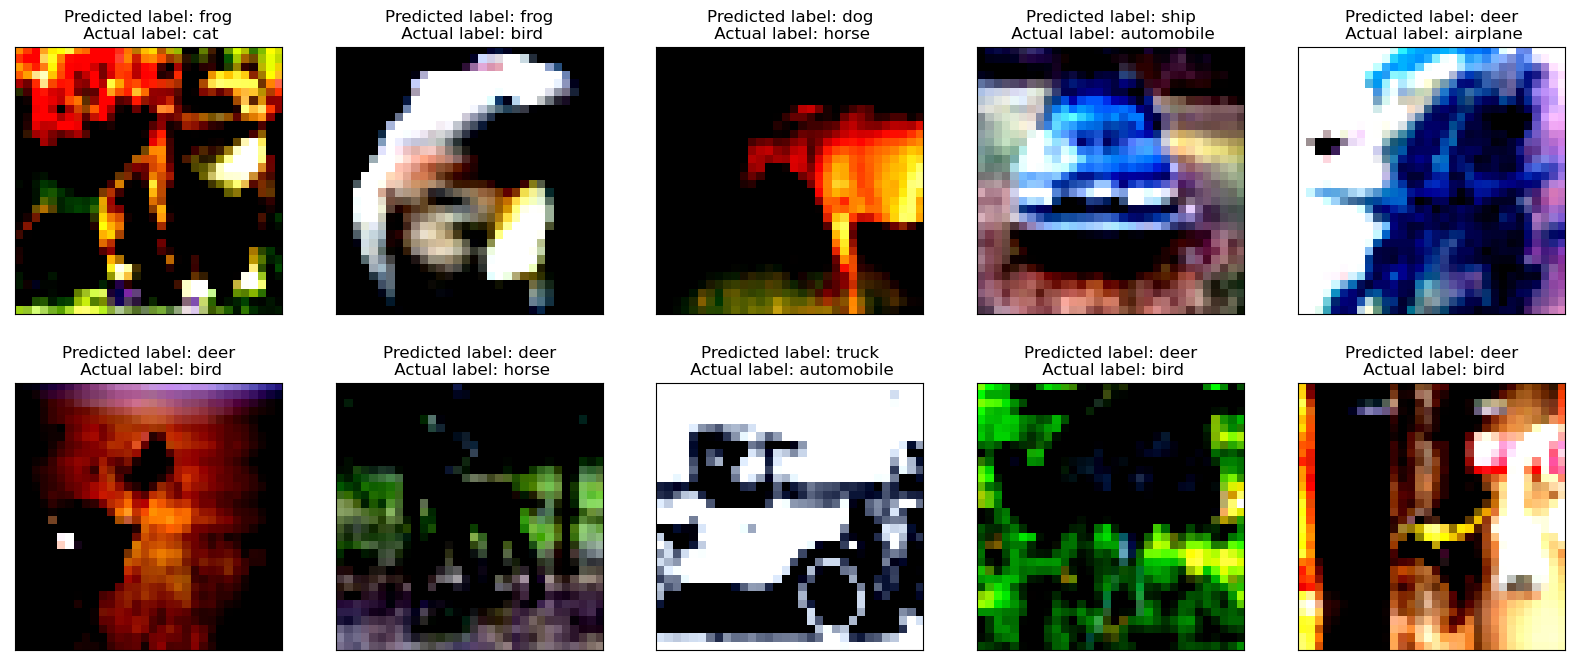

In [19]:
import numpy as np
fig = plt.figure(figsize=(20, 8))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = incorrect_examples[0][idx]
    img = img/2 + 0.5
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(incorrect_examples[0][idx], (1, 2, 0)))
    ax.set_title(f"Predicted label: {classes[incorrect_pred[0][idx]]}\n Actual label: {classes[incorrect_labels[0][idx]]}")
    